In [65]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd
from geopy.distance import great_circle
from matplotlib.patches import Rectangle

import xarray as xr


plt.close('all')

## Getting the Data

## Functions:


In [66]:
def get_coast():
    f = open('CO.txt', 'r') # 'r' = read
    k=int(0)
    BADVAL=float('NaN')

    # check file size first
    for line in f:
        k+=1
    
    print('number of coatline points is ' + str(k))
    
    # declare arrays to store lat lon vetctor data
    la=np.zeros(k)
    lo=np.zeros(k)
    k=int(0)
    f.close()

    f = open('CO.txt', 'r')
    for line in f:
        if (line[0]=='*'):
            la[k]=BADVAL
            lo[k]=BADVAL
        else:
            lo[k]=float(line[0:13])
            la[k]=float(line[14:27])
        k+=1
    f.close()

    return (lo,la)

In [67]:
def get_drifters():
    print("Read data ")
    dat=np.loadtxt('drifters.txt')
    BAD=float(0)
    Min_numpoints=int(10)
    # remember index 0 and [] for acessing index in array
    lo=np.array(dat[:,3])
    la=np.array(dat[:,4])
    u=np.array(dat[:,6])
    v=np.array(dat[:,7])

    d=np.array(dat[:,5])# drogue

    # save only good points d=1 and u,v != 1000.00
    i_g1=np.where(u!=1000.00)
    i_g2=np.where(d == 1)

    i_g=np.intersect1d(i_g1,i_g2)
    lo=lo[i_g]
    la=la[i_g]
    u=u[i_g]
    v=v[i_g]


    # domain
    dx=float(1) # 1 degree cells
    long=np.linspace(-100, 0, 101)
    lati=np.linspace(10, 70, 61)
    s=(len(lati),len(long))
    U=np.zeros(s)
    V=np.zeros(s)
    X=np.zeros(s)
    Y=np.zeros(s)

    print("Search in grid ")
    kla=int(-1)
    for ila in tqdm(lati):
        kla+=1
        klo=int(-1)
        print(ila)
        for ilo in long:
            klo+=1
        # print([long[ilo],lati[ila]])
            # find indicies of data points in that cell
            indx_1=np.where(lo>ilo-dx)
            indx_2=np.where(lo<ilo+dx)
            lon_indx=np.intersect1d(indx_1,indx_2)
            indx_1=np.where(la>ila-dx)
            indx_2=np.where(la<ila+dx)
            lat_indx=np.intersect1d(indx_1,indx_2)
            indx_cell=np.intersect1d(lon_indx,lat_indx)
            X[kla,klo]=np.array(ilo)
            Y[kla,klo]=np.array(ila)
            if(len(indx_cell) >= Min_numpoints):
                U[kla,klo]=np.mean(u[indx_cell])
                V[kla,klo]=np.mean(v[indx_cell])
            else:
                U[kla,klo]=BAD
                V[kla,klo]=BAD

    return (long,lati,U,V)


In [68]:
def get_drifter_data():
    dat=np.loadtxt('drifters.txt')
    BAD=float(0)
    Min_numpoints=int(10)
    df = pd.read_csv('drifters.txt'
            ,names=  ("idx","id","time","lon","lat","drouge","u","v")
            ,sep= "\s+"
            )

    # remember index 0 and [] for acessing index in array
    id=np.array(dat[:,1]) 
    t =np.array(dat[:,2]) # time
    lo=np.array(dat[:,3]) # longitude
    la=np.array(dat[:,4]) # latitude
    d=np.array(dat[:,5]) # drogue
    u=np.array(dat[:,6]) # zonal component
    v=np.array(dat[:,7]) # meridional component
    
    # save only good points d=1 and u,v != 1000.00
    i_g1=np.where(u!=1000.00)
    i_g2=np.where(d == 1)
    
    df1 = df[(df.u != 1000.00) & (df.drouge == 1)]
    return df1
    

## Code:

In [69]:
df = pd.read_csv('drifters.txt'
            ,names=  ("idx","id","time","lon","lat","drouge","u","v")
            ,sep= "\s+"
            )
id_array = [55151,62229,2556336,9712733,9814538,9914698]
id_array = [39236,62897]
df1 = df[(df.u != 1000.00) & (df.drouge == 1) & (np.isin(df.id,id_array))]
df1["m"] = np.sqrt(df1.u**2+df1.v**2)

/var/folders/tn/jn9dcwbs4b947qcv03hznrn00000gn/T/ipykernel_86835/342656267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["m"] = np.sqrt(df1.u**2+df1.v**2)


In [70]:

print("mean u:",df1.u.mean(),"| max u:",df1.u.max(),"| min u:",df1.u.min())
print("mean v:",df1.v.mean(),"| max v:",df1.v.max(),"| min v:",df1.v.min())
print("mean m:",df1.m.mean(),"| max m:",df1.m.max(),"| min m:",df1.m.min())

print()

mean u: -7.400721370604147 | max u: 53.48 | min u: -62.0
mean v: 3.5618845807033366 | max v: 63.03 | min v: -73.88
mean m: 22.208393645053118 | max m: 86.71979301174558 | min m: 1.1261438629233835



In [71]:
df1.time

286874    733169.0
286875    733170.0
286876    733171.0
286877    733172.0
286878    733173.0
            ...   
569463    734808.5
569464    734809.5
569465    734810.5
569466    734811.5
569467    734812.5
Name: time, Length: 1109, dtype: float64

In [72]:
df1["date_time"] = datetime(year=1, month=1, day=1) + timedelta(days=1)*df1["time"]

/var/folders/tn/jn9dcwbs4b947qcv03hznrn00000gn/T/ipykernel_86835/391658873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["date_time"] = datetime(year=1, month=1, day=1) + timedelta(days=1)*df1["time"]


In [73]:

print("initial date:",df1["date_time"].iloc[0].strftime("%d %B %Y")
      ,"| final date:",df1["date_time"].iloc[-1].strftime("%d %B %Y"))
print("total time (days):",df1["date_time"].iloc[-1] -df1["date_time"].iloc[0])
print("first position: (", df1.lat.iloc[0],df1.lon.iloc[0],")"
      ,"| final position: (", df1.lat.iloc[-1],df1.lon.iloc[-1],")")


initial date: 08 May 2008 | final date: 06 November 2012
total time (days): 1643 days 12:00:00
first position: ( 12.181 -46.278 ) | final position: ( 30.161 -65.219 )


In [74]:
def gcd(lat1, lon1, lat2, lon2):
    ponto1 = (lat1, lon1)
    ponto2 = (lat2, lon2)
    dist_cmax = great_circle(ponto1, ponto2).kilometers
    return dist_cmax

displacement (km): 2793.497486349615



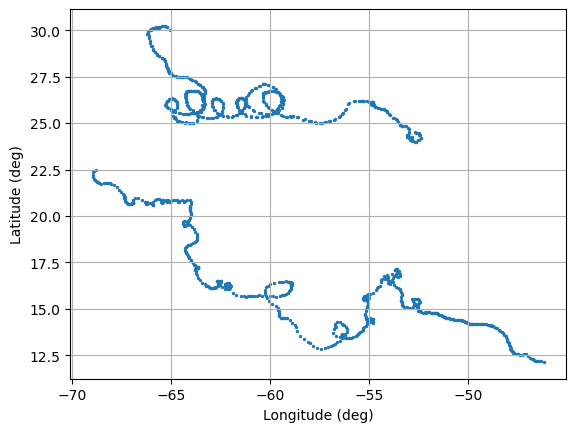

In [75]:
dist_cmax=gcd(df1.lat.iloc[0],df1.lon.iloc[0],df1.lat.iloc[-1],df1.lon.iloc[-1])
print("displacement (km):",dist_cmax)
print()

plt.figure()
#lo,la = get_coast()
plt.scatter(df1.lon,df1.lat,s = 2)
#plt.quiver(lo1,la1,u1,v1)
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.grid()

number of coatline points is 61632


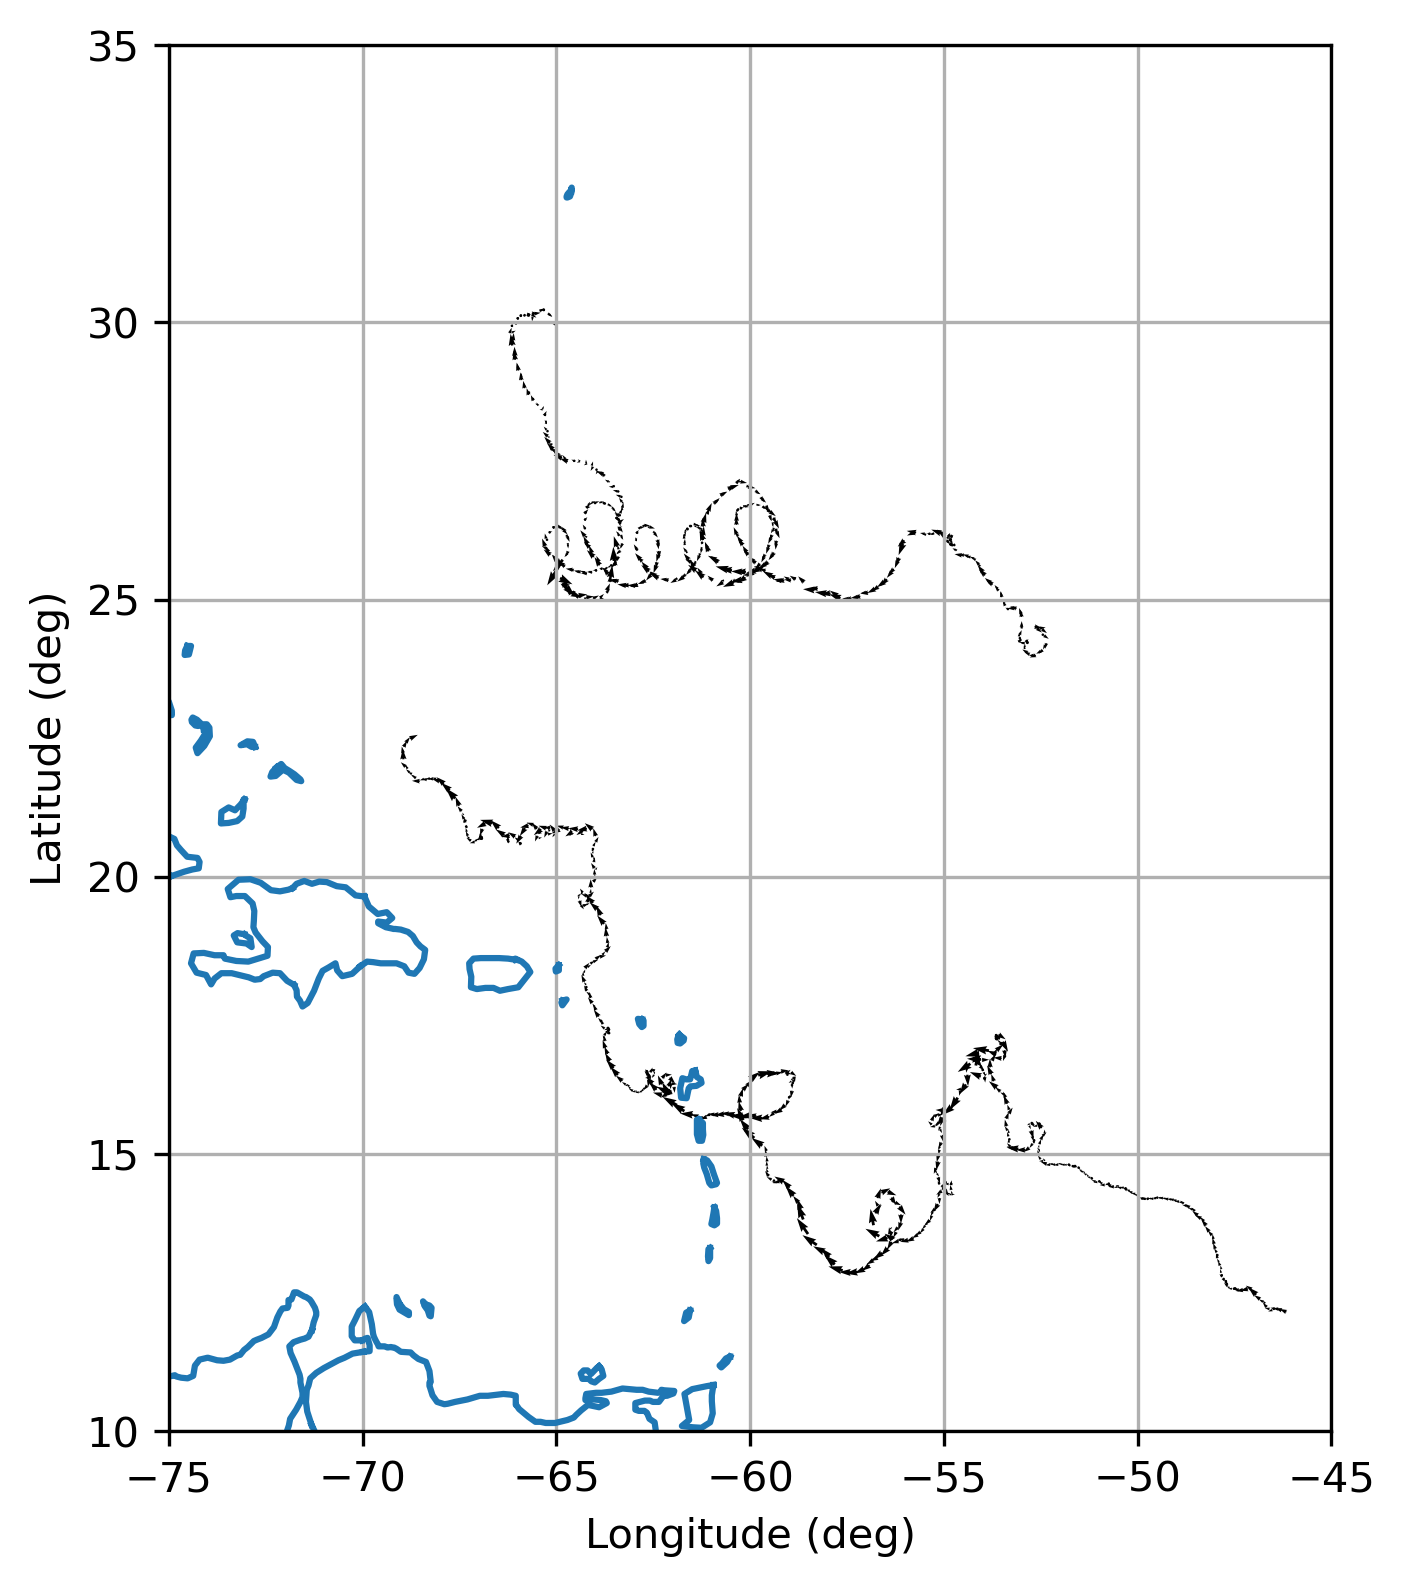

In [76]:
y_lo = 10
y_up = 35
x_lo = -75
x_up = -45

faktor = (x_up-x_lo)/(y_up-y_lo)
siz = 5
plt.figure(dpi = 300,figsize = (siz,siz*faktor))
lo,la = get_coast()
plt.plot(lo,la) #coast lines
plt.quiver(df1.lon,df1.lat,df1.u,df1.v,scale=4500,label='Drifter direction')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')

plt.ylim(y_lo,y_up)
plt.xlim(x_lo,x_up)
plt.grid()
plt.show()

In [77]:
df1[df1["id"] == 62897].describe()

idx       id           time         lon         lat  drouge  \
count   598.0    598.0     598.000000  598.000000  598.000000   598.0   
mean   2197.0  62897.0  733318.000000  -57.774244   16.387338     1.0   
min    2197.0  62897.0  733169.000000  -68.955000   12.149000     1.0   
25%    2197.0  62897.0  733243.250000  -63.736250   14.422000     1.0   
50%    2197.0  62897.0  733318.000000  -56.600500   15.811000     1.0   
75%    2197.0  62897.0  733392.750000  -53.321500   17.322250     1.0   
max    2197.0  62897.0  733467.000000  -46.161000   22.493000     1.0   
std       0.0      0.0      86.385642    6.151766    2.608169     0.0   

                u           v           m            date_time  
count  598.000000  598.000000  598.000000                  598  
mean    -9.360736    4.457391   22.837876  2008-10-04 00:00:00  
min    -62.000000  -47.980000    2.321250  2008-05-08 00:00:00  
25%    -18.512500   -6.015000   13.527800  2008-07-21 06:00:00  
50%     -9.670000    4.855000   20.234071  2008-10-04 00:00:00  
75%      0.170000   15.480000   29.268954  2008-12-17 18:00:00  
max     53.480000   63.030000   75.189926  2009-03-02 00:00:00  
std     16.703131   17.176943   12.620282                  NaN

In [78]:
df1[df1["id"] == 39236].describe()

idx       id          time         lon         lat  drouge  \
count   511.0    511.0     511.00000  511.000000  511.000000   511.0   
mean   3040.0  39236.0  734685.50000  -60.969178   26.268033     1.0   
min    3040.0  39236.0  734558.00000  -66.204000   23.995000     1.0   
25%    3040.0  39236.0  734621.75000  -64.082500   25.501500     1.0   
50%    3040.0  39236.0  734685.50000  -61.685000   26.055000     1.0   
75%    3040.0  39236.0  734749.25000  -59.395000   26.647500     1.0   
max    3040.0  39236.0  734813.00000  -52.352000   30.229000     1.0   
std       0.0      0.0      73.82863    3.952920    1.303593     0.0   

                u           v           m            date_time  
count  511.000000  511.000000  511.000000                  511  
mean    -5.107006    2.513914   21.471740  2012-07-02 12:00:00  
min    -47.780000  -73.880000    1.126144  2012-02-26 00:00:00  
25%    -17.335000   -8.770000   13.906986  2012-04-29 18:00:00  
50%     -4.980000    3.710000   20.183867  2012-07-02 12:00:00  
75%      8.350000   13.830000   28.612560  2012-09-04 06:00:00  
max     47.770000   54.810000   86.719793  2012-11-07 00:00:00  
std     16.720979   16.185596   10.587250                  NaN

# Exercise 1 EKE

In [79]:
idx = 3040
start = 365
end = 451
df2 = df1[df1["idx"] == idx].iloc[start:end]

number of coatline points is 61632


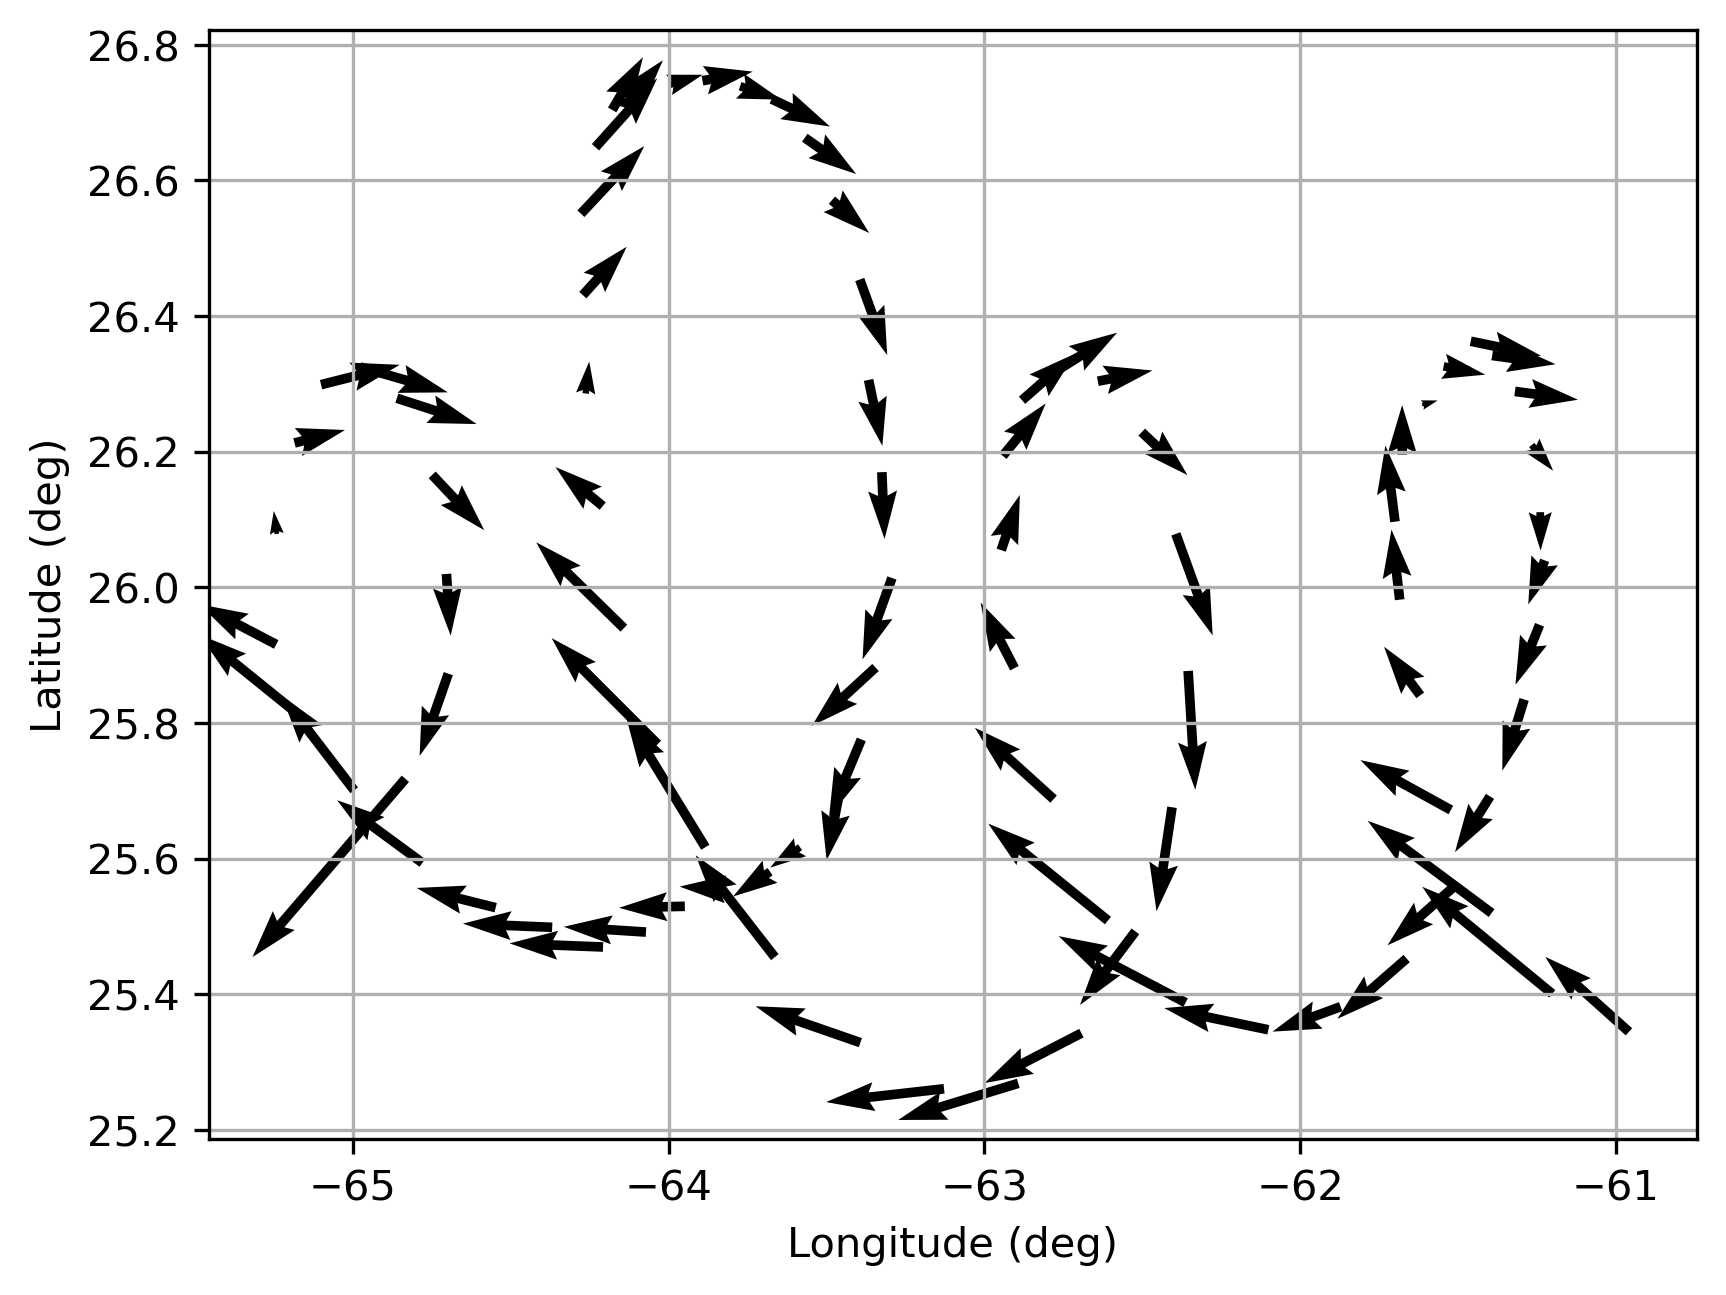

In [80]:
plt.figure(dpi = 300)
lo,la = get_coast()
#plt.plot(lo,la) #coast lines
#plt.plot(lo1,la1,'r--',label='Drifter trajectory') #trajetória do drifter
plt.quiver(df2.lon,df2.lat,df2.u,df2.v
           #,scale=1000
           ,label='Drifter direction')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.grid()
#plt.ylim(25,50)
#plt.xlim(-100,-10)
plt.show()

## Calculating the Radius

In [81]:
df2

idx     id      time     lon     lat  drouge      u      v  \
569322  3040  39236  734667.5 -60.959  25.345       1 -20.82  18.66   
569323  3040  39236  734668.5 -61.202  25.401       1 -32.35  26.64   
569324  3040  39236  734669.5 -61.394  25.520       1 -30.85  22.97   
569325  3040  39236  734670.5 -61.523  25.672       1 -22.52  12.41   
569326  3040  39236  734671.5 -61.620  25.841       1  -9.00  12.09   
...      ...    ...       ...     ...     ...     ...    ...    ...   
569403  3040  39236  734748.5 -64.861  26.279       1  19.86  -6.43   
569404  3040  39236  734749.5 -64.749  26.166       1  12.95 -13.77   
569405  3040  39236  734750.5 -64.704  26.020       1   1.06 -15.36   
569406  3040  39236  734751.5 -64.698  25.873       1  -7.14 -20.49   
569407  3040  39236  734752.5 -64.834  25.718       1 -38.05 -44.38   

                m           date_time  
569322  27.958326 2012-06-14 12:00:00  
569323  41.907184 2012-06-15 12:00:00  
569324  38.462233 2012-06-16 12:00:00  
569325  25.713003 2012-06-17 12:00:00  
569326  15.072097 2012-06-18 12:00:00  
...           ...                 ...  
569403  20.874973 2012-09-03 12:00:00  
569404  18.902788 2012-09-04 12:00:00  
569405  15.396532 2012-09-05 12:00:00  
569406  21.698380 2012-09-06 12:00:00  
569407  58.458420 2012-09-07 12:00:00  

[86 rows x 10 columns]

In [82]:
from scipy.signal import argrelextrema
n = 5 

df2["min"] = df2.iloc[argrelextrema(df2.lon.values, np.less_equal,
                    order=n)[0]]['lon']

df2["max"] = df2.iloc[argrelextrema(df2.lon.values, np.greater_equal,
                    order=n)[0]]['lon']

In [83]:

min = df2.iloc[argrelextrema(df2.lon.values, np.less_equal,
                    order=n)[0]]['lon'].to_numpy()[0::]
max = df2.iloc[argrelextrema(df2.lon.values, np.greater_equal,
                    order=n)[0]]['lon'].to_numpy()[1::]
max

array([-61.226, -62.355, -63.293, -64.698])

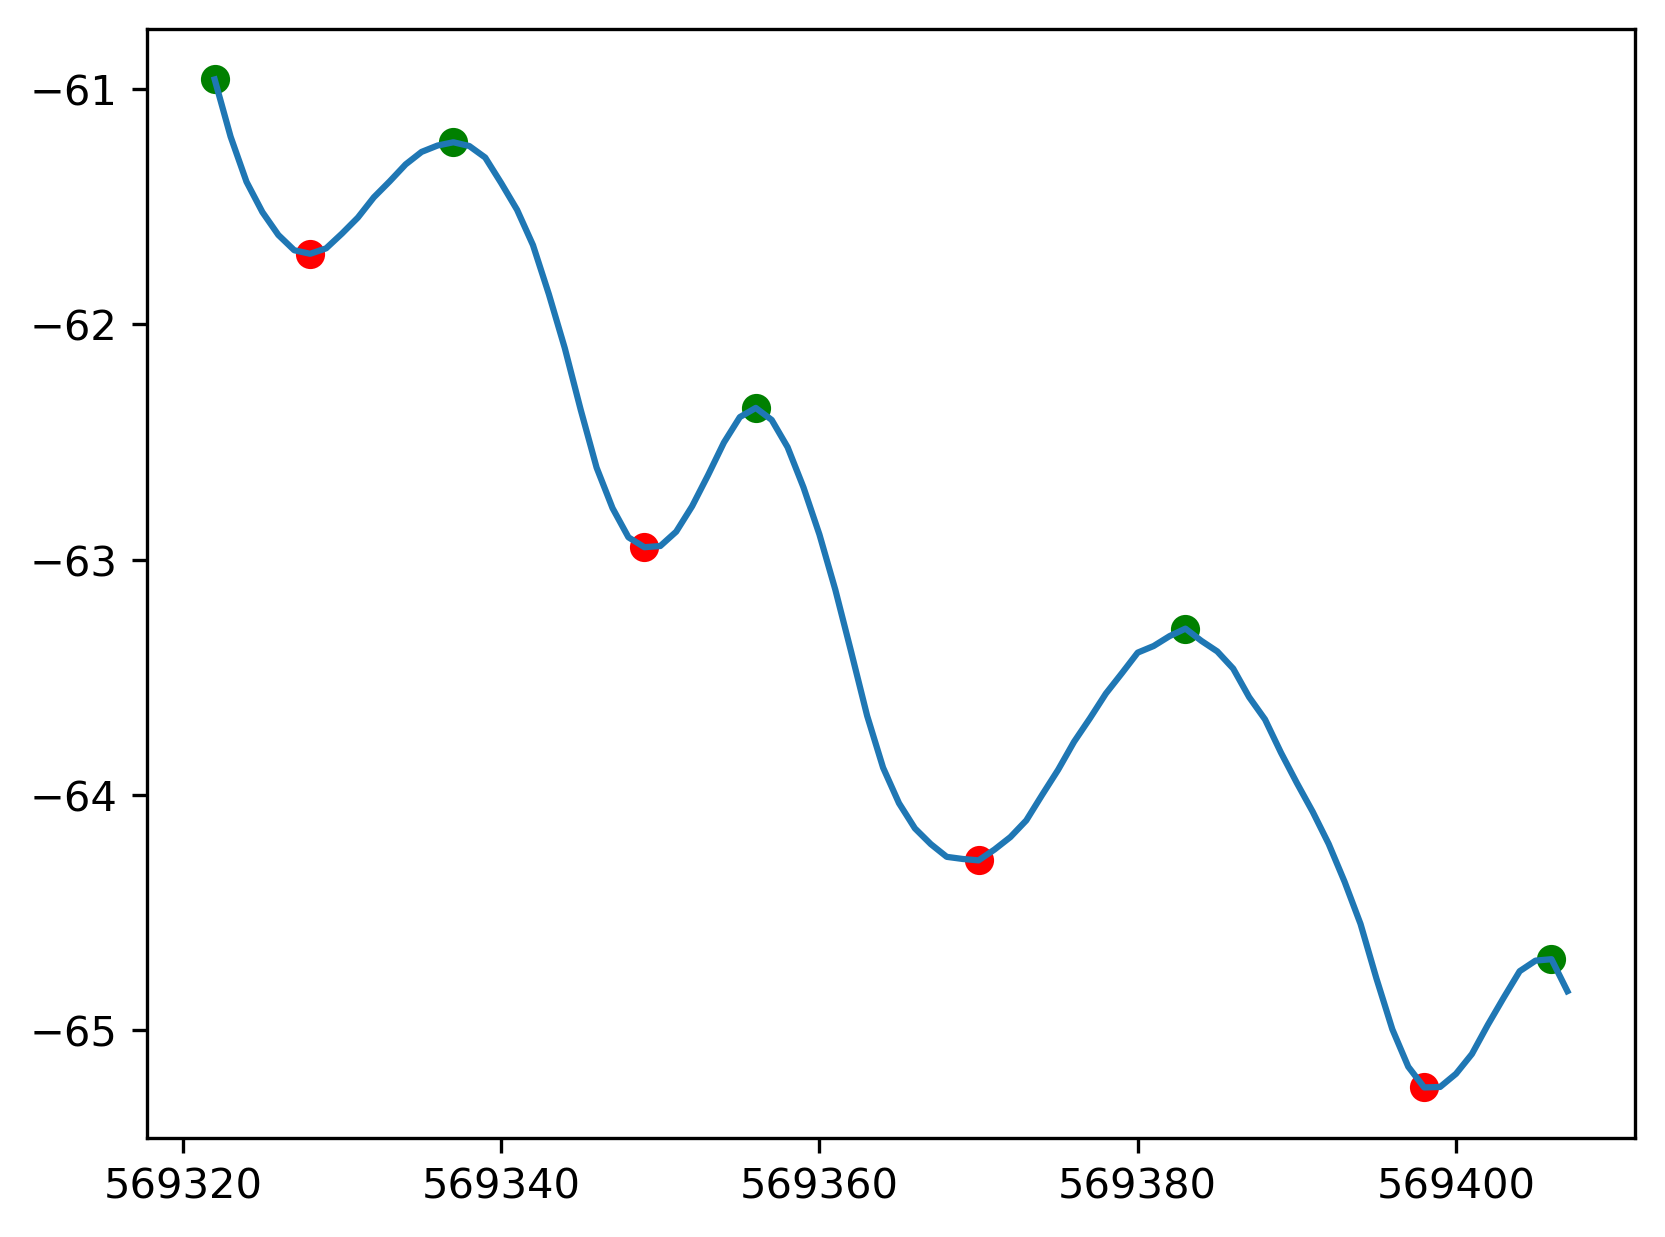

In [84]:
plt.figure(dpi = 300)
plt.scatter(df2.index, df2['min'], c='r')
plt.scatter(df2.index, df2['max'], c='g')
plt.plot(df2.index, df2['lon'])
plt.show()

In [85]:
max-min

array([0.474, 0.592, 0.985, 0.545])

In [86]:
df2.iloc[argrelextrema(df2.lon.values, np.greater_equal,order=n)[0]]['lon'][1::].to_numpy() - df2.iloc[argrelextrema(df2.lon.values, np.less_equal,order=n)[0]]['lon'].to_numpy()

array([0.474, 0.592, 0.985, 0.545])

Turbulent Velocity $u' = u - \bar{u}$

In [99]:
df2["u_prime"] = df2.u-df2.u.mean()
df2["v_prime"] = df2.v-df2.v.mean()
df2["u2+v2"] = df2["u_prime"]**2+df2["v_prime"]**2

Eddy Kinetic Energy 
$$\overline{EKE} = \overline{\frac{u_i^2 + v_i^2}{2}}$$
$$ \overline{|\vec{v_R}|} = \overline{\sqrt{u_i^2+v_i^2}} = \omega R$$
$$ \zeta = \frac{\omega}{R}$$
$$ \omega =\frac{\overline{|\vec{v_R}|}}{R}$$


In [107]:
EKE = df2["u2+v2"].mean()/2
print(f"Eddy Kinetic Energy: {EKE}")

v_R = np.sqrt(df2["u2+v2"]).mean()
print(f"v_R: {v_R}")

omega = v_R/(max-min).mean()
print(f"Omega: {omega}")

Eddy Kinetic Energy: 237.80765124391561
v_R: 20.414486617607917
Omega: 31.455295250551274


number of coatline points is 61632


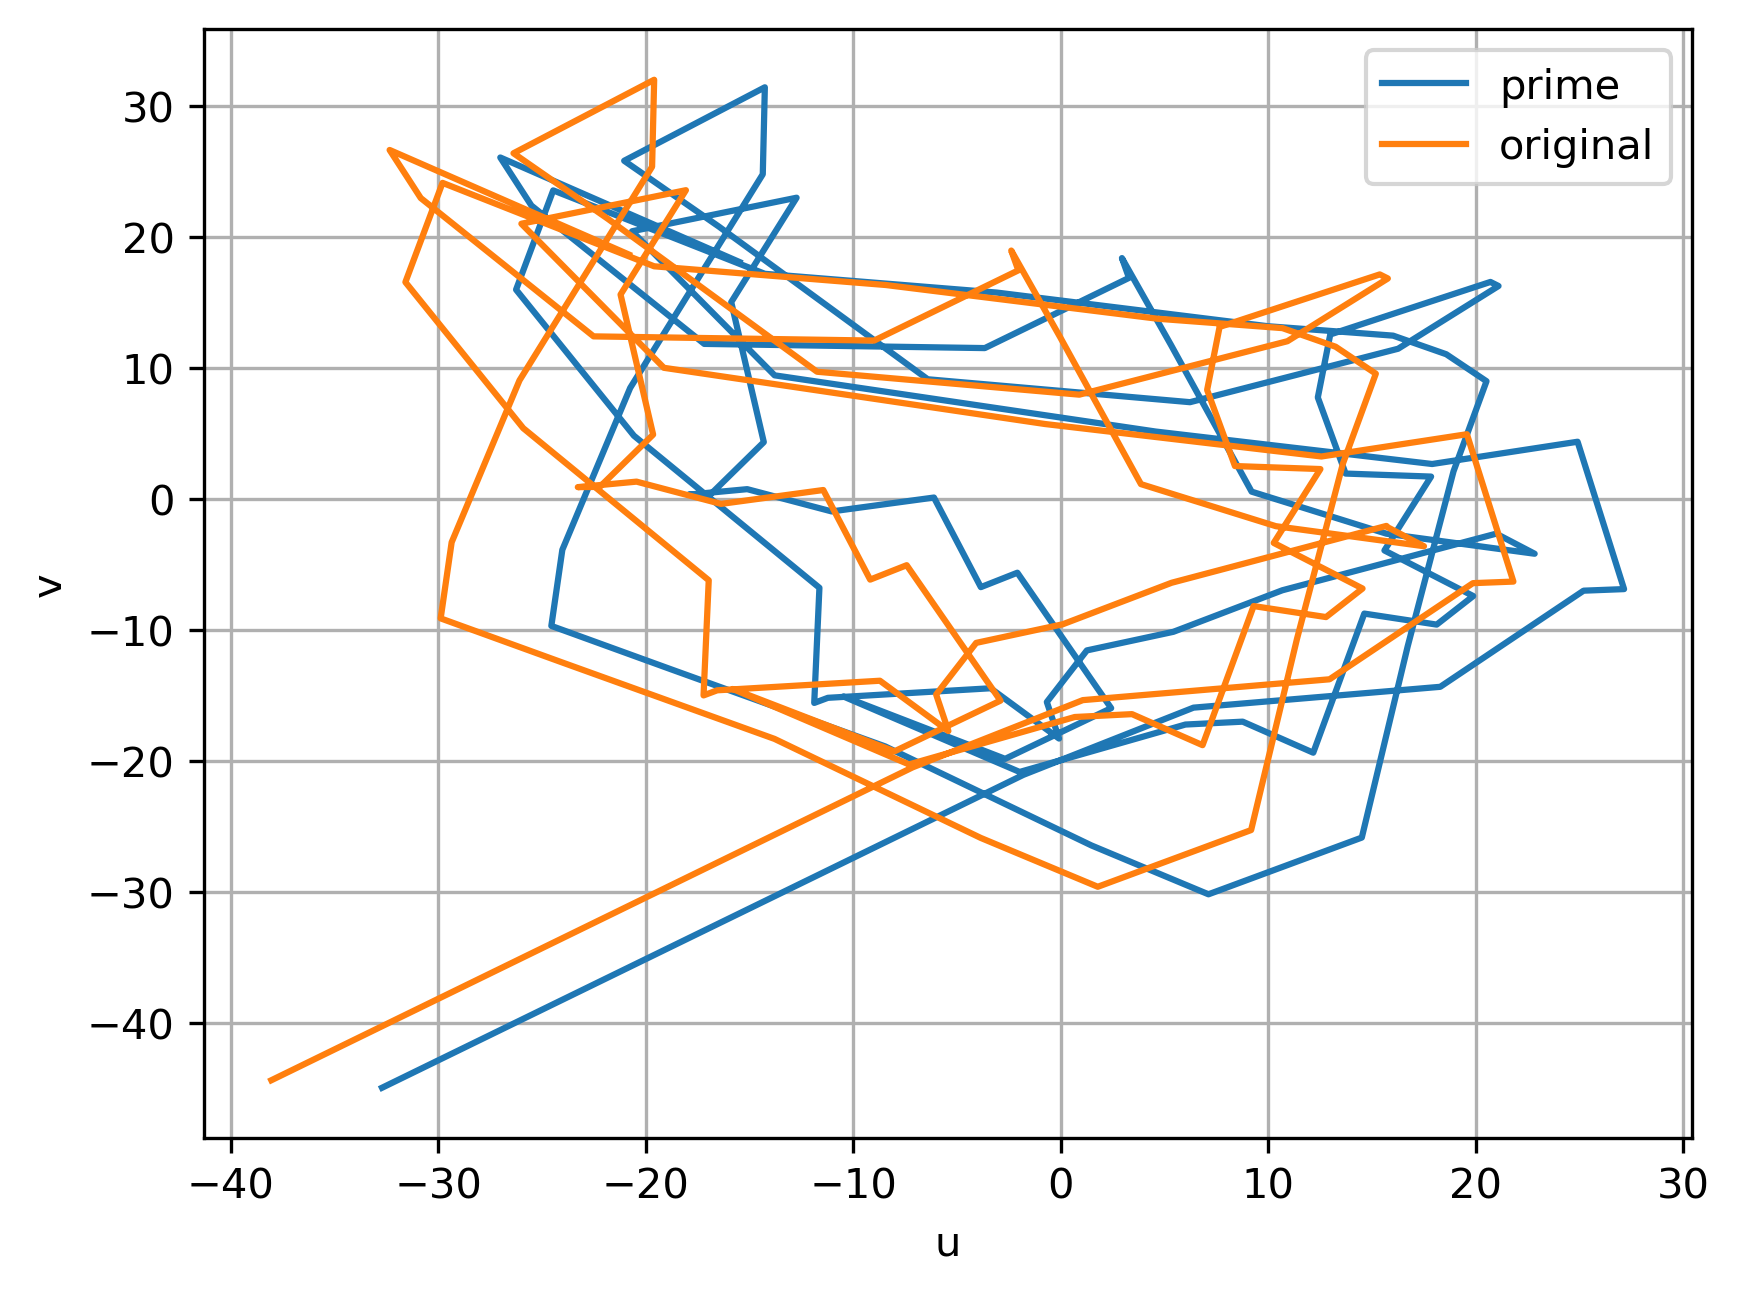

In [94]:
plt.figure(dpi = 300)
lo,la = get_coast()
#plt.plot(lo,la) #coast lines
#plt.plot(lo1,la1,'r--',label='Drifter trajectory') #trajetória do drifter
plt.plot(df2["u_prime"],df2["v_prime"]
           #,scale=1000
           ,label='prime')
plt.plot(df2["u"],df2["v"]
           #,scale=1000
           ,label='original')
# plt.quiver(df2.lon,df2.lat,df2["u_prime"],df2["v_prime"]
#         #,scale=1000
#         ,label='Drifter direction')
plt.xlabel('u')
plt.ylabel('v')
plt.grid()
#plt.ylim(25,50)
#plt.xlim(-100,-10)
plt.legend()
plt.show()

In [50]:
df

idx        id      time     lon     lat  drouge        u        v
0          1   7706856  726028.0 -89.862  10.165       1  1000.00  1000.00
1          1   7706856  726029.0 -90.009  10.267       1    14.24    22.05
2          1   7706856  726030.0 -89.879  10.173       1    -3.42   -32.30
3          1   7706856  726031.0 -90.008  10.058       1   -16.45     6.36
4          1   7706856  726032.0 -90.047  10.159       1    17.02     2.76
...      ...       ...       ...     ...     ...     ...      ...      ...
684655  3730  63738740  736784.0 -39.500  63.707       0    -4.66     6.86
684656  3730  63738740  736785.0 -39.554  63.717       0   -15.14    -1.89
684657  3730  63738740  736786.0 -39.781  63.693       0     2.18    -3.82
684658  3730  63738740  736787.0 -39.731  63.673       0    -5.18     3.45
684659  3730  63738740  736788.0 -39.906  63.725       0   -17.34    -0.66

[684660 rows x 8 columns]

# New Exercise: Ocean Drift Golf Stream

number of coatline points is 61632


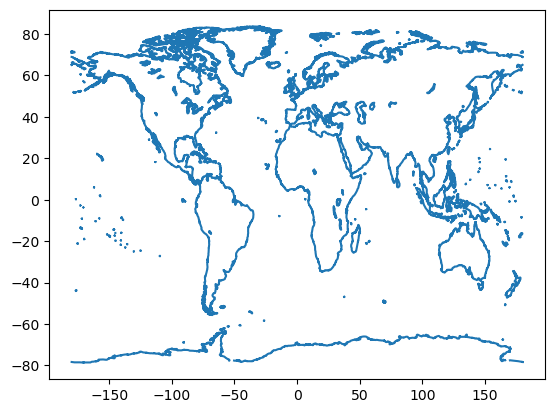

In [51]:
plt.figure()
lo,la = get_coast()
plt.plot(lo,la) #coast lines

In [52]:
df3 = df[(df.u != 1000.00) & (df.drouge == 1)]
df3["m"] = np.sqrt(df3.u**2+df3.v**2)

/var/folders/tn/jn9dcwbs4b947qcv03hznrn00000gn/T/ipykernel_86835/595774076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["m"] = np.sqrt(df3.u**2+df3.v**2)


number of coatline points is 61632


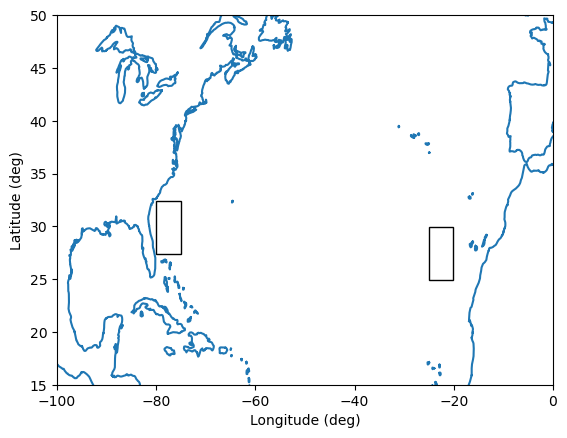

In [53]:
plt.figure()
lo,la = get_coast()
plt.plot(lo,la) #coast lines
#plt.plot(lo1,la1,'r--',label='Drifter trajectory') #trajetória do drifter
#plt.quiver(df3.lon,df3.lat,df3.u,df3.v,scale=4500,label='Drifter direction')

box1_X, box1_Y = -80, 27.5
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((box1_X - .1, box1_Y - .1), 5, 5, fill=None, alpha=1))
box2_X, box2_Y = -25, 25
currentAxis.add_patch(Rectangle((box2_X - .1, box2_Y - .1), 5, 5, fill=None, alpha=1))
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.ylim(15,50)
plt.xlim(-100,0)
plt.show()

In [54]:
df_box1 = df3[(df3.lon >= box1_X) & (df3.lon <= box1_X+5) & (df3.lat >= box1_Y) & (df3.lat <= box1_Y+5)]
df_box2 = df3[(df3.lon >= box2_X) & (df3.lon <= box2_X+5) & (df3.lat >= box2_Y) & (df3.lat <= box2_Y+5)]

In [55]:
df_box1["idx"].unique()

array([  85,  343,  514,  520,  772,  838,  973,  976, 1126, 1132, 1150,
       1153, 1279, 1363, 1378, 1381, 1435, 1501, 1603, 1630, 1633, 1636,
       1657, 1660, 1666, 1669, 1834, 1882, 1891, 1897, 1948, 1954, 1990,
       1993, 2011, 2014, 2020, 2122, 2131, 2149, 2194, 2218, 2260, 2299,
       2311, 2365, 2386, 2389, 2404, 2440, 2446, 2464, 2467, 2479, 2494,
       2500, 2530, 2542, 2551, 2587, 2647, 2650, 2662, 2686, 2707, 2719,
       2791, 2812, 2896, 2908, 2968, 2989, 3007, 3013, 3049, 3064, 3070,
       3073, 3085, 3100, 3109, 3148, 3172, 3178, 3196, 3199, 3202, 3253,
       3265, 3283, 3316, 3367, 3373, 3412, 3415, 3439, 3571, 3685])

In [56]:
df_box2["idx"].unique()

array([  31,   49,   88,  187,  205,  529, 1186, 1288, 1336, 1441, 1546,
       1570, 1621, 1729, 1753, 2683, 2698, 2752, 2857, 2878, 3031, 3286,
       3313, 3538])

In [57]:
for idx in df_box2["idx"].unique():
    min_time = df_box2[df_box2["idx"] == idx]["time"].min()
    df3 = df3.drop(df3[(df3['time'] < min_time) & (df3["idx"] == idx)].index)

In [58]:
for idx in df_box1["idx"].unique():
    min_time = df_box1[df_box1["idx"] == idx]["time"].min()
    df3 = df3.drop(df3[(df3['time'] < min_time) & (df3["idx"] == idx)].index)

number of coatline points is 61632


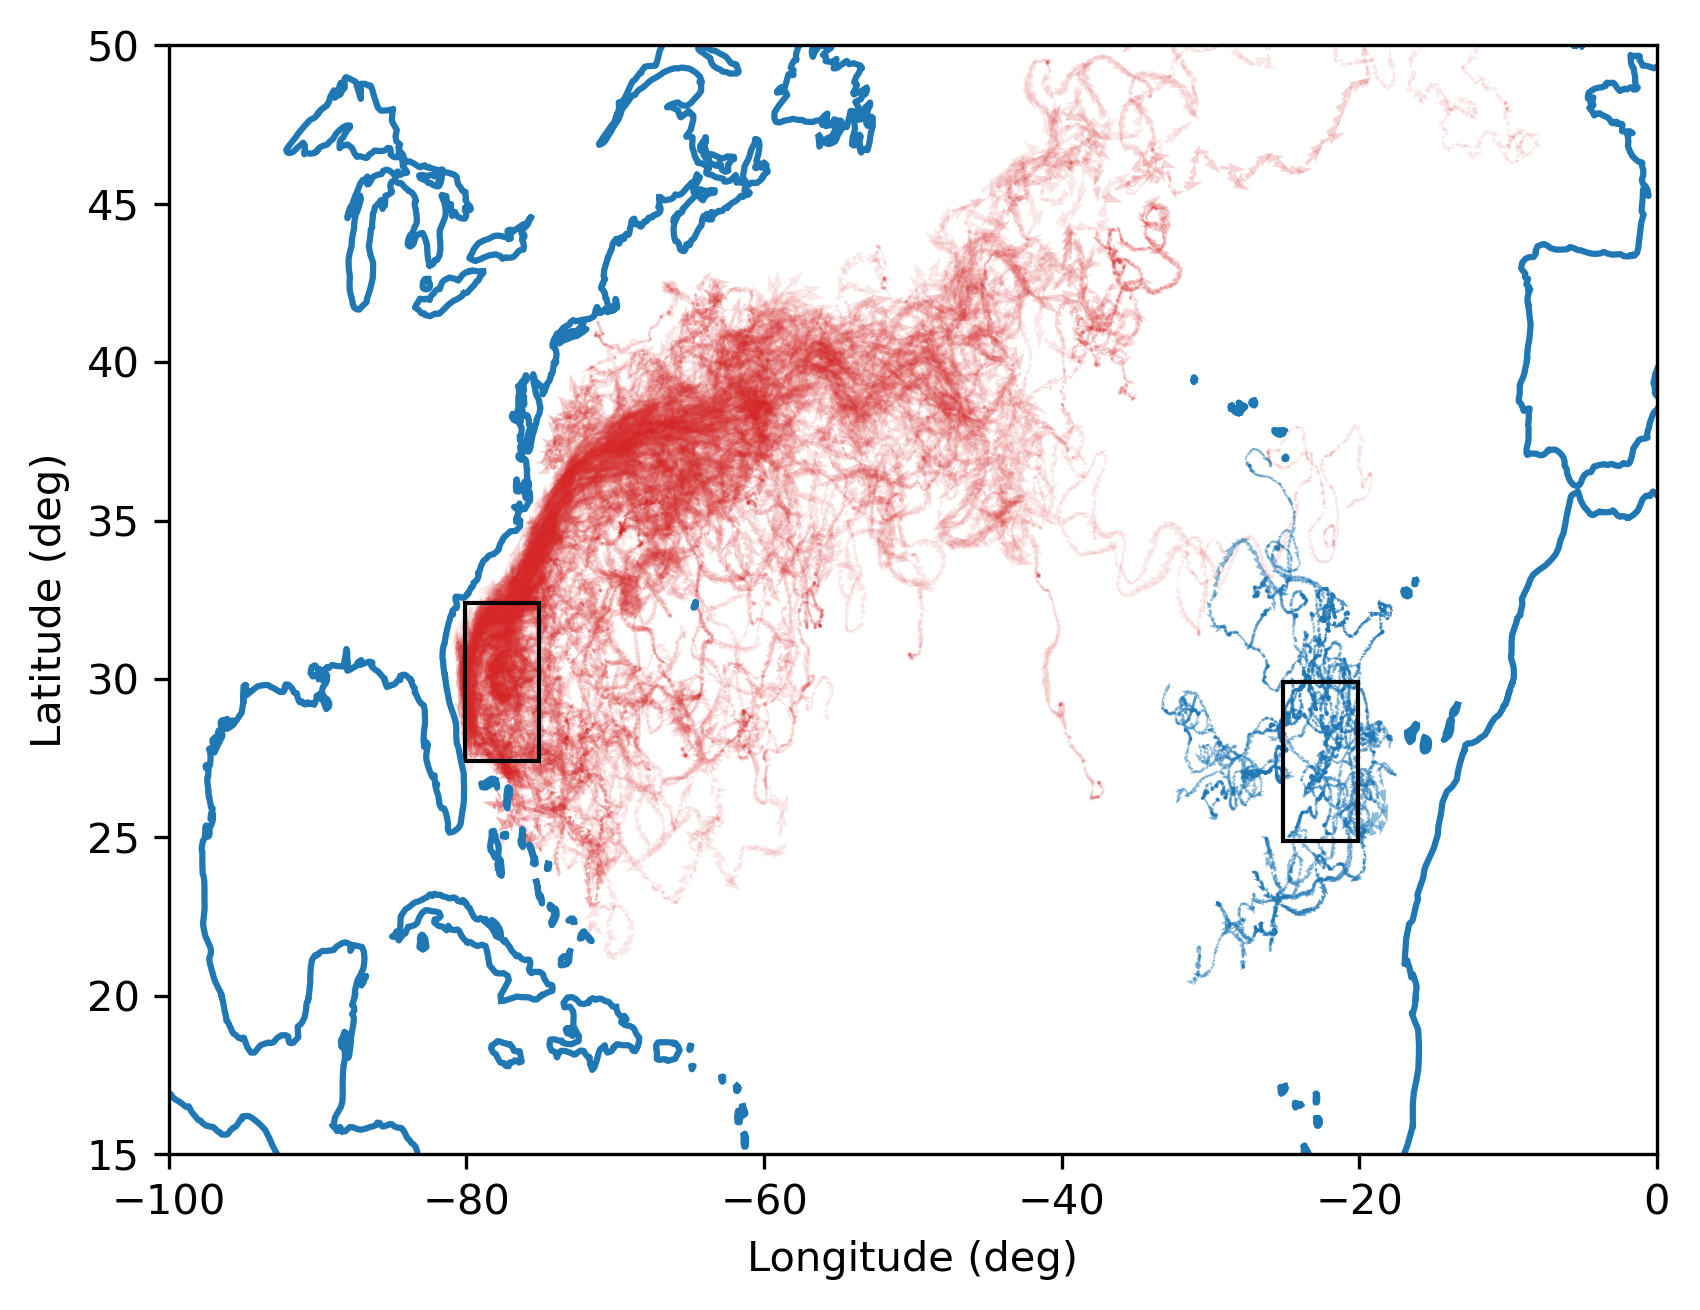

In [59]:
plt.figure(dpi = 300)
lo,la = get_coast()
plt.plot(lo,la) #coast lines
#plt.plot(lo1,la1,'r--',label='Drifter trajectory') #trajetória do drifter
plt.quiver(df3[np.isin(df3.idx,df_box2["idx"].unique())].lon
           ,df3[np.isin(df3.idx,df_box2["idx"].unique())].lat
           ,df3[np.isin(df3.idx,df_box2["idx"].unique())].u
           ,df3[np.isin(df3.idx,df_box2["idx"].unique())].v
           ,scale=4500
           ,alpha = 0.5
           ,label='Drifter direction'
           ,color = "tab:blue"
           )

plt.quiver(df3[np.isin(df3.idx,df_box1["idx"].unique())].lon
           ,df3[np.isin(df3.idx,df_box1["idx"].unique())].lat
           ,df3[np.isin(df3.idx,df_box1["idx"].unique())].u
           ,df3[np.isin(df3.idx,df_box1["idx"].unique())].v
           ,scale=4500
           ,alpha = 0.1
           ,label='Drifter direction'
           ,color = "tab:red"
           )

box1_X, box1_Y = -80, 27.5
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((box1_X - .1, box1_Y - .1), 5, 5, fill=None, alpha=1))
box2_X, box2_Y = -25, 25
currentAxis.add_patch(Rectangle((box2_X - .1, box2_Y - .1), 5, 5, fill=None, alpha=1))
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.ylim(15,50)
plt.xlim(-100,0)
plt.show()

# Mean Drifter Exercise

In [60]:
df4 = df[(df.u != 1000.00) & (df.drouge == 1)]
df4["m"] = np.sqrt(df4.u**2+df4.v**2)

/var/folders/tn/jn9dcwbs4b947qcv03hznrn00000gn/T/ipykernel_86835/3555510073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["m"] = np.sqrt(df4.u**2+df4.v**2)


In [61]:
dx = 2.0  # New grid spacing for longitude and latitude
Min_numpoints= 10

# Define the extent
long_start, long_end = -100, 0
lat_start, lat_end = 10, 70

# Calculate the number of points based on the new grid spacing
num_long_points = int((long_end - long_start) / dx) + 1
num_lat_points = int((lat_end - lat_start) / dx) + 1

# Create the longitude and latitude grids with the adjusted spacing
long = np.linspace(long_start, long_end, num_long_points)
lati = np.linspace(lat_start, lat_end, num_lat_points)
s=(len(lati),len(long))

In [62]:

U=np.zeros(s)
V=np.zeros(s)
X=np.zeros(s)
Y=np.zeros(s)

print("Search in grid ")
kla=int(-1)
for ila in lati:
    kla+=1
    klo=int(-1)
    print(ila)
    for ilo in long:
        klo+=1
       # print([long[ilo],lati[ila]])
        # find indicies of data points in that cell
        df_loop = df4[(df4.lon >= ilo-dx) & (df4.lon <= ilo+dx) & (df4.lat >= ila-dx) & (df4.lat <= ila+dx)]
        
        X[kla,klo]=np.array(ilo)
        Y[kla,klo]=np.array(ila)
        if(len(df_loop) >= Min_numpoints):
            U[kla,klo]= df_loop["u"].mean()
            V[kla,klo]= df_loop["v"].mean()
        else:
            U[kla,klo]= np.NaN
            V[kla,klo]= np.NaN
   
print("Ploting ")


Search in grid 
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
Ploting 


number of coatline points is 61632


(-100.0, 0.0)

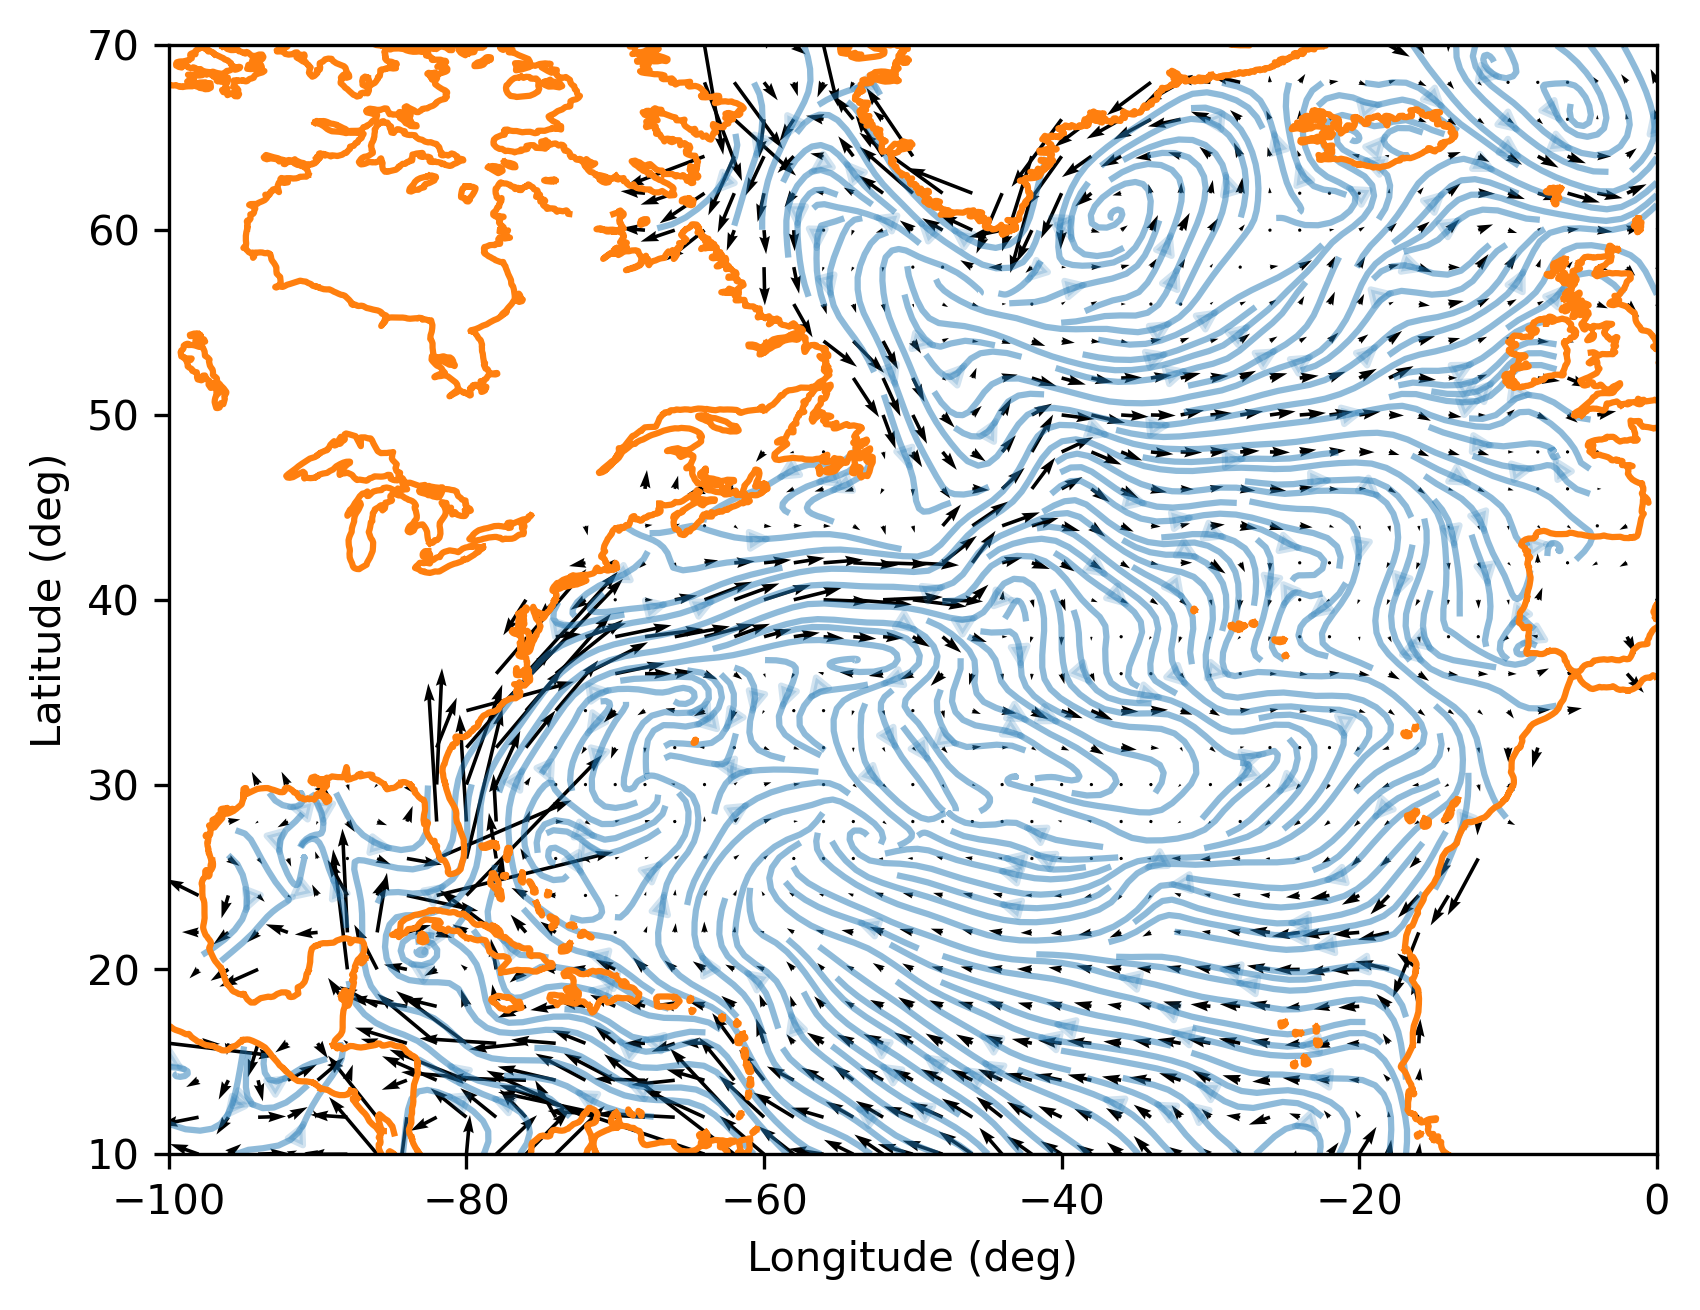

In [63]:
plt.figure(dpi = 300)


streamline = True
if streamline:
    c = plt.streamplot(long,lati,U,V,density = 3)
    c.lines.set_alpha(0.5)
    ax = plt.gca()
    for art in ax.get_children():
        if not isinstance(art, matplotlib.patches.FancyArrowPatch):
            continue
        art.set_alpha(0.2)
        #art.remove()

lo,la = get_coast()
plt.plot(lo,la, color = "tab:orange")

plt.quiver(long,lati,U,V)

plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.ylim(10,70)
plt.xlim(-100,0)







In [64]:
plt.figure(dpi = 300)


plt.quiver(df3[np.isin(df3.idx,df_box2["idx"].unique())].lon
           ,df3[np.isin(df3.idx,df_box2["idx"].unique())].lat
           ,df3[np.isin(df3.idx,df_box2["idx"].unique())].u
           ,df3[np.isin(df3.idx,df_box2["idx"].unique())].v
           ,scale=4500
           ,alpha = 0.3
           ,label='Drifter direction'
           ,color = "tab:green"
           )

plt.quiver(df3[np.isin(df3.idx,df_box1["idx"].unique())].lon
           ,df3[np.isin(df3.idx,df_box1["idx"].unique())].lat
           ,df3[np.isin(df3.idx,df_box1["idx"].unique())].u
           ,df3[np.isin(df3.idx,df_box1["idx"].unique())].v
           ,scale=4500
           ,alpha = 0.1
           ,label='Drifter direction'
           ,color = "tab:red"
           )

box1_X, box1_Y = -80, 27.5
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((box1_X - .1, box1_Y - .1), 5, 5, fill=None, alpha=1))
box2_X, box2_Y = -25, 25
currentAxis.add_patch(Rectangle((box2_X - .1, box2_Y - .1), 5, 5, fill=None, alpha=1))

streamline = True
if streamline:
    c = plt.streamplot(long,lati,U,V,density = 3)
    c.lines.set_alpha(0.5)
    ax = plt.gca()
    for art in ax.get_children():
        if not isinstance(art, matplotlib.patches.FancyArrowPatch):
            continue
        art.set_alpha(0.2)
        #art.remove()

lo,la = get_coast()
plt.plot(lo,la, color = "tab:orange")

plt.quiver(long,lati,U,V)

plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.ylim(10,70)
plt.xlim(-100,0)





number of coatline points is 61632


(-100.0, 0.0)